In [1]:
using Oceananigans
using Oceananigans.Units: minutes, hours,day

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA C:\Users\shiva\.julia\packages\CUDA\DL5Zo\src\initialization.jl:42


In [2]:
Nz=128
Lz=120

refinement=1.2
stretching=12

h(k)=(k-1)/Nz                          #Height of n_th cell
ζ₀(k) = 1 + (h(k) - 1) / refinement
Σ(k) = (1 - exp(-stretching * h(k))) / (1 - exp(-stretching))
z_faces(k) =Lz * (ζ₀(k) * Σ(k) - 1)
grid = RectilinearGrid(size=(64,Nz), x = (0, 64),z = z_faces,topology=(Periodic, Flat, Bounded))

RectilinearGrid{Float64, Periodic, Flat, Bounded}
             architecture: CPU()
                   domain: x ∈ [0.0, 64.0], y ∈ [1.0, 1.0], z ∈ [-120.0, 0.0]
                 topology: (Periodic, Flat, Bounded)
        size (Nx, Ny, Nz): (64, 1, 128)
        halo (Hx, Hy, Hz): (1, 0, 1)
             spacing in x: Regular, with spacing 1.0
             spacing in y: Flattened
             spacing in z: Stretched, with spacing min=0.781322, max=1.859718

In [3]:
buoyancy_flux(x,y,t,params)=params.initial_buoyancy_flux*exp(-t^4/(24*params.shut_off_time^4))
buoyancy_flux_parameters = (initial_buoyancy_flux=1e-8,shut_off_time=2hours)
buoyancy_flux_bc=FluxBoundaryCondition(buoyancy_flux,parameters=buoyancy_flux_parameters)

BoundaryCondition: classification=Flux, condition=buoyancy_flux(x, y, t, params) in Main at In[3]:1


(process:4912): GLib-GIO-WARNING **: 14:15:09.750: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.2.12.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 46 extensions but has no verbs


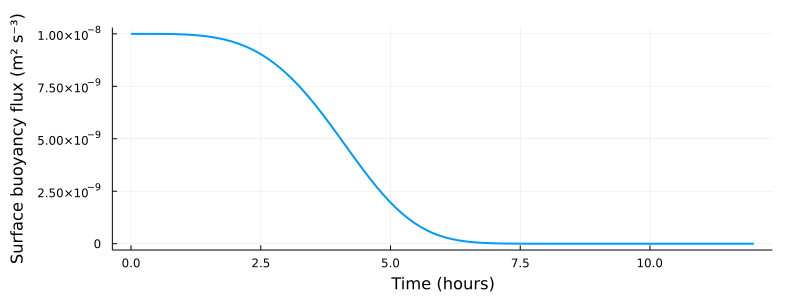

In [4]:
using Plots,Measures
times = range(0, 12hours, length=100)

flux_plot = plot(times ./ hours, [buoyancy_flux(0, 0, t, buoyancy_flux_parameters) for t in times],
                 linewidth = 2, xlabel = "Time (hours)", ylabel = "Surface buoyancy flux (m² s⁻³)",
                 size = (800, 300), margin = 5mm, label = nothing)

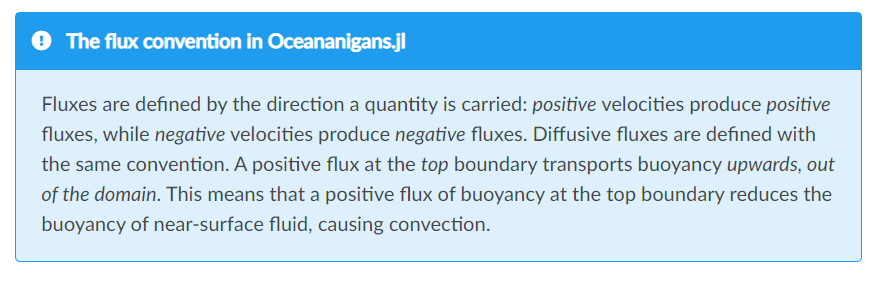
how??

In [5]:
N² = 1e-4 # s⁻²

buoyancy_gradient_bc = GradientBoundaryCondition(N²)

BoundaryCondition: classification=Gradient, condition=0.0001

In [6]:
buoyancy_bcs = FieldBoundaryConditions(top = buoyancy_flux_bc, bottom = buoyancy_gradient_bc)

Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── east: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── south: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── north: Oceananigans.BoundaryConditions.DefaultPrognosticFieldBoundaryCondition
├── bottom: BoundaryCondition{Oceananigans.BoundaryConditions.Gradient, Float64}
├── top: BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Oceananigans.BoundaryConditions.ContinuousBoundaryFunction{Nothing, Nothing, Nothing, Nothing, typeof(buoyancy_flux), NamedTuple{(:initial_buoyancy_flux, :shut_off_time), Tuple{Float64, Float64}}, Tuple{}, Nothing, Nothing}}
└── immersed: BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}

In [7]:
growing_and_grazing(x, y, z, t, P, params) = (params.μ₀ * exp(z / params.λ) - params.m) * P

growing_and_grazing (generic function with 1 method)

In [8]:
plankton_dynamics_parameters = (μ₀ = 1/day,λ = 5, m = 0.1/day) 

(μ₀ = 1.1574074074074073e-5, λ = 5, m = 1.1574074074074074e-6)

In [9]:
plankton_dynamics = Forcing(growing_and_grazing, field_dependencies = :P,
                            parameters = plankton_dynamics_parameters)

ContinuousForcing{NamedTuple{(:μ₀, :λ, :m), Tuple{Float64, Int64, Float64}}}
├── func: growing_and_grazing
├── parameters: (μ₀ = 1.1574074074074073e-5, λ = 5, m = 1.1574074074074074e-6)
└── field dependencies: (:P,)

In [10]:
model = NonhydrostaticModel(
                   grid = grid,
              advection = UpwindBiasedFifthOrder(),
            timestepper = :RungeKutta3,
                closure = IsotropicDiffusivity(ν=1e-4, κ=1e-4),
               coriolis = FPlane(f=1e-4),
                tracers = (:b, :P,:T,:S),
               buoyancy = BuoyancyTracer(),
                forcing = (P=plankton_dynamics,),
    boundary_conditions = (b=buoyancy_bcs,)
)

┌ Warning: Inflating model grid halo size to (3, 0, 3) and recreating grid. The model grid will be different from the input grid. To avoid this warning, pass halo=(3, 0, 3) when constructing the grid.
└ @ Oceananigans.Models.NonhydrostaticModels C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Models\NonhydrostaticModels\nonhydrostatic_model.jl:130


NonhydrostaticModel{CPU, Float64}(time = 0 seconds, iteration = 0) 
├── grid: RectilinearGrid{Float64, Periodic, Flat, Bounded}(Nx=64, Ny=1, Nz=128)
├── tracers: (:b, :P, :T, :S)
├── closure: IsotropicDiffusivity{Oceananigans.TurbulenceClosures.ExplicitTimeDiscretization, Float64, NamedTuple{(:b, :P, :T, :S), NTuple{4, Float64}}}
├── buoyancy: BuoyancyTracer
└── coriolis: FPlane{Float64}

In [12]:
mixed_layer_depth = 40

stratification(z) = z<-mixed_layer_depth ? N² * z : - N² * mixed_layer_depth

noise(z) = 1e-4 * N² * grid.Lz * randn() * exp(z/ 4)

initial_buoyancy(x, y, z) = stratification(z) + noise(z)


set!(model, b=initial_buoyancy,T=1,S=35, P=1)

In [ ]:
zpq=LinRange(0, 100, 1000)
wer=zeros(size(zpq))


plot(initial_buoyancy.(0, 0, zpq),zpq)


In [13]:
simulation = Simulation(model, Δt=2minutes, stop_time=24hours)

Simulation{typename(NonhydrostaticModel){typename(CPU), Float64}}
├── Model clock: time = 0 seconds, iteration = 0
├── Next time step: 2 minutes
├── Elapsed wall time: 0 seconds
├── Stop time: 1 day
├── Stop iteration : Inf
├── Wall time limit: Inf
├── Callbacks: typename(OrderedCollections.OrderedDict) with 4 entries:
│   ├── stop_time_exceeded => typename(Callback)
│   ├── stop_iteration_exceeded => typename(Callback)
│   ├── wall_time_limit_exceeded => typename(Callback)
│   └── nan_checker => typename(Callback)
├── Output writers: typename(OrderedCollections.OrderedDict) with no entries
└── Diagnostics: typename(OrderedCollections.OrderedDict) with no entries

In [14]:
wizard = TimeStepWizard(cfl=1.0, max_change=1.1, max_Δt=2minutes)

simulation.callbacks[:wizard] = Callback(wizard, IterationInterval(10))

Callback{TimeStepWizard{Float64, typeof(Oceananigans.Utils.cell_advection_timescale), typeof(Oceananigans.Simulations.infinite_diffusion_timescale)}, IterationInterval}(TimeStepWizard{Float64, typeof(Oceananigans.Utils.cell_advection_timescale), typeof(Oceananigans.Simulations.infinite_diffusion_timescale)}(1.0, Inf, 1.1, 0.5, 120.0, 0.0, Oceananigans.Utils.cell_advection_timescale, Oceananigans.Simulations.infinite_diffusion_timescale), IterationInterval(10))

In [25]:
averaged_plankton = Field(Average(model.tracers.P, dims=(1, 2)))
averaged_bouyancy = Field(Average(model.tracers.b, dims=(1, 2)))
outputs = (w = model.velocities.w,
           plankton = model.tracers.P,bouyancy=model.tracers.b,
           averaged_plankton = averaged_plankton,averaged_bouyancy = averaged_bouyancy)

simulation.output_writers[:simple_output] =
    JLD2OutputWriter(model, outputs,
                     schedule = TimeInterval(20minutes),
                     prefix = "convecting_plankton1",
                     force = true)


┌ Warning: Cannot serialize timeseries/bouyancy/serialized/boundary_conditions as it contains functions. Will replace with missing. Function boundary conditions must be restored manually.
└ @ Oceananigans.OutputWriters C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\OutputWriters\output_writer_utils.jl:65


JLD2OutputWriter scheduled on TimeInterval(20 minutes):
├── filepath: .\convecting_plankton1.jld2
├── 5 outputs: (:w, :plankton, :bouyancy, :averaged_plankton, :averaged_bouyancy)
├── field slicer: FieldSlicer(:, :, :, with_halos=false)
├── array type: Array{Float32}
├── including: [:grid, :coriolis, :buoyancy, :closure]
└── max filesize: Inf YiB

In [16]:
run!(simulation)

┌ Info: Initializing simulation...
└ @ Oceananigans.Simulations C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Simulations\run.jl:168
┌ Info:     ... simulation initialization complete (17.528 seconds)
└ @ Oceananigans.Simulations C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Simulations\run.jl:190
┌ Info: Executing initial time step...
└ @ Oceananigans.Simulations C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Simulations\run.jl:113
┌ Info:     ... initial time step complete (1.758 minutes).
└ @ Oceananigans.Simulations C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Simulations\run.jl:120
┌ Info: Simulation is stopping. Model time 1 day has hit or exceeded simulation stop time 1 day.
└ @ Oceananigans.Simulations C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Simulations\simulation.jl:164


In [17]:
using JLD2

file = jldopen(simulation.output_writers[:simple_output].filepath)

iterations = parse.(Int, keys(file["timeseries/t"]))

times = [file["timeseries/t/$iter"] for iter in iterations]

buoyancy_flux_time_series = [buoyancy_flux(0, 0, t, buoyancy_flux_parameters) for t in times]


73-element Vector{Float64}:
 1.0e-8
 9.99967850311051e-9
 9.994857289905093e-9
 9.973992212338234e-9
 9.91803324769311e-9
 9.80106657945981e-9
 9.591894571091381e-9
 9.257115036306362e-9
 8.766151199017037e-9
 8.098246793420792e-9
 7.250591381346758e-9
 6.245579480856017e-9
 5.134171190325918e-9
 ⋮
 4.73447551287943e-202
 4.8204700854738e-215
 1.1138059772422492e-228
 5.565296994253388e-243
 5.725938867995897e-258
 1.154171737982417e-273
 4.333214967063968e-290
 2.878602534006701e-307
 0.0
 0.0
 0.0
 0.0

In [18]:
xw, yw, zw = nodes(model.velocities.w)
xp, yp, zp = nodes(model.tracers.P)
xb,yb,zb= nodes(model.tracers.b)

([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5  …  54.5, 55.5, 56.5, 57.5, 58.5, 59.5, 60.5, 61.5, 62.5, 63.5], StepRangeLen(1.0, 0.0, 1), [-119.07014101046333, -117.22684986527355, -115.41779070478643, -113.64534192012289, -111.91118207641048, -110.21639612003739, -108.56156818149199, -106.94686252235103, -105.37209400516595, -103.83678931317631  …  -7.422870321760815, -6.641475211268997, -5.86009170300996, -5.078718844084797, -4.297355759228503, -3.516001644546285, -2.7346557617492473, -1.9533174328502234, -1.171986035283481, -0.3906609974150732])

In [23]:
using Printf

@info "Making a movie about plankton..."

w_lim = 0   # the maximum(abs(w)) across the whole timeseries

for (i, iteration) in enumerate(iterations)
    w = file["timeseries/w/$iteration"][:, 1, :]

    global w_lim = maximum([w_lim, maximum(abs.(w))])
end

anim = @animate for (i, iteration) in enumerate(iterations)

    @info "Plotting frame $i from iteration $iteration..."

    t = file["timeseries/t/$iteration"]
    w = file["timeseries/w/$iteration"][:, 1, :]
    P = file["timeseries/plankton/$iteration"][:, 1, :]
    b = file["timeseries/bouyancy/$iteration"][:, 1, :]
    averaged_P = file["timeseries/averaged_plankton/$iteration"][1, 1, :]
    averaged_b = file["timeseries/averaged_bouyancy/$iteration"][1, 1, :]

    P_min = minimum(P) - 1e-9
    P_max = maximum(P) + 1e-9
    P_lims = (0.95, 1.1)

    w_levels = range(-w_lim, stop=w_lim, length=20)

    P_levels = collect(range(P_lims[1], stop=P_lims[2], length=20))
    P_lims[1] > P_min && pushfirst!(P_levels, P_min)
    P_lims[2] < P_max && push!(P_levels, P_max)

    kwargs = (xlabel="x (m)", ylabel="y (m)", aspectratio=1, linewidth=0, colorbar=true,
              xlims=(0, model.grid.Lx), ylims=(-model.grid.Lz, 0))

    w_contours = contourf(xw, zw, w';
                          color = :balance,
                          levels = w_levels,
                          clims = (-w_lim, w_lim),
                          kwargs...)

    P_contours = contourf(xp, zp, clamp.(P, P_lims[1], P_lims[2])';
                          color = :matter,
                          levels = P_levels,
                          clims = P_lims,
                          kwargs...)

#     P_profile = plot(averaged_P, zp,
#                      linewidth = 2,
#                      label = nothing,
#                      xlims = (0.9, 1.3),
#                      ylabel = "z (m)",
                     xlabel = "Plankton concentration (μM)")
#      b_profile =contourf(xb, zb, b';
#                           color = :balance,
#                           levels = w_levels,
#                           clims = (-w_lim, w_lim),
#                           kwargs...)
#     b_profile = plot(b', zb,
#                      linewidth = 2,
#                      label = nothing,
#                      ylabel = "z (m)",
#                      xlabel = "Boubancy")
     b_profile = plot(averaged_b, yb,
                     linewidth = 2,
                     label = nothing,
                     ylabel = "Z (m)",
                     xlabel = "bouyancy")

    flux_plot = plot(times ./ hours, buoyancy_flux_time_series,
                     linewidth = 1,
                     label = "Buoyancy flux time series",
                     color = :black,
                     alpha = 0.4,
                     legend = :topright,
                     xlabel = "Time (hours)",
                     ylabel = "Buoyancy flux (m² s⁻³)",
                     ylims = (0.0, 1.1 * buoyancy_flux_parameters.initial_buoyancy_flux))

    plot!(flux_plot, times[1:i] ./ hours, buoyancy_flux_time_series[1:i],
          color = :steelblue,
          linewidth = 6,
          label = nothing)

    scatter!(flux_plot, times[i:i] / hours, buoyancy_flux_time_series[i:i],
             markershape = :circle,
             color = :steelblue,
             markerstrokewidth = 0,
             markersize = 15,
             label = "Current buoyancy flux")

    layout = Plots.grid(2, 2, widths=(0.7, 0.3))

    w_title = @sprintf("Vertical velocity (m s⁻¹) at %s", prettytime(t))
    P_title = @sprintf("Plankton concentration (μM) at %s", prettytime(t))

    plot(w_contours, flux_plot, P_contours, b_profile,title=[w_title "" P_title ""],layout=layout, size=(1000.5, 1000.5))
end


┌ Info: Making a movie about plankton...
└ @ Main In[23]:3


LoadError: syntax: "for" at In[23]:13 expected "end", got ")"

In [20]:
gif(anim,"Convecting_plankton.gif",fps=5)

LoadError: UndefVarError: anim not defined

In [ ]:
# Tem =Array(interior(model.tracers.b))[:, 1, :]
# Sen=Array(interior(model.tracers.S))[:, 1, :]
xb,yb,zb= nodes(model.tracers.b)
